# PROJECT SPRINT 10: A/B TESTING

### DESCRIPTION OF THE PROJECT: This is a test and analysis done for a big online store. Together with the marketing department, I received a list of hypotheses that may help boost revenue.<br>

### PURPOSE OF THE TEST: **Prioritize these hypotheses, launch A/B test and analyze the results.** 

***

### The project is divided into several parts. Each part has its own purpose and is outlined in a sequencial order so you can follow the progress to the end.<br>

>### Part One: Pre-processing of the data.<br>
>### Part Two: Check Compliances.<br>
>### Part Three: Main KPIs (without statistical analysis).<br>
>### Part Four: Prioritizing Hypotheses.<br>
>### Part Five: A/B Test Analysis.<br>
>### Part Six: Conlusions based on the A/B test results.

***

### Description of the data:<br>
> Hypotheses dataset:<br>
> Hypotheses — brief descriptions of the hypotheses<br>
> Reach — user reach, on a scale of one to ten<br>
> Impact — impact on users, on a scale of one to ten<br>
> Confidence — confidence in the hypothesis, on a scale of one to ten<br>
> Effort — the resources required to test a hypothesis, on a scale of one to ten.<br>

> Orders dataset:<br>
> transactionId — order identifier<br>
> visitorId — identifier of the user who placed the order<br>
> date — of the order<br>
> revenue — from the order<br>
> group — the A/B test group that the user belongs to<br>

> Visits dataset:<br>
> date — date<br>
> group — A/B test group<br>
> visits — the number of visits on the date specified in the A/B test group specified

***

### Part One: Pre-processing the data

#### In this part I will import libraries, check and clean the data from both datasets, and check any inconsistencies of the data that may prevent to do further actions and analysis.

**1. Libraries**

In [443]:
# import all the necessary libraries for the whole project
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import sidetable
import plotly.express as px 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 

**2. Reading the datasets and checking for missing values**

In [444]:
# reading the orders csv file
orders = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_10/project/orders_us.csv', parse_dates=['date'])
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [445]:
# info about the dataframe
orders.stb.missing(style=True)

,missing,total,percent
transactionId,0,"1,197",0.00%
visitorId,0,"1,197",0.00%
date,0,"1,197",0.00%
revenue,0,"1,197",0.00%
group,0,"1,197",0.00%


* We can see that there are 1197 rows and no missing vallues.

In [446]:
# reading the visits csv file
visits = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_10/project/visits_us.csv', parse_dates=['date'])
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [447]:
# info about the visits dataframe
visits.stb.missing(style=True)

,missing,total,percent
date,0,62,0.00%
group,0,62,0.00%
visits,0,62,0.00%


* We can see that there are 62 rows and no missing values.

In [448]:
# checking for duplicates on column of transactions
duplicates = orders['transactionId'].duplicated().sum()
if duplicates > 0:
  print(f'There are {duplicates} duplicate rows in the DataFrame.')
else:
  print('No duplicate rows found.')

No duplicate rows found.


* We can see that there are no duplicated transactions on the dataframe.

In [449]:
# group by test group and see when start and when ends the test
orders.groupby(['group'])['date'].agg(['min','max'])

,min,max
group,,
A,2019-08-01,2019-08-31
B,2019-08-01,2019-08-31


* We can see that both orders and visits dataframes have same start and end dates.

***

### Part Two: Check compliances

#### In this part I will go through all the technical requirements that need to be fulfilled in order to perform a correct test.

In [450]:
# group by group to see how many users on each group
orders.groupby(['group'])['visitorId'].nunique()

group
A    503
B    586
Name: visitorId, dtype: int64

* We can see there is not an even split of the groups, I will check if there are users that are included on both groups by error on the next step.

In [451]:
# pylint: disable=missing-final-newline
# users in both groups
both_groups = list(orders.groupby(['visitorId'])['group'].nunique().reset_index().query('group > 1')['visitorId'])
both_groups

[8300375,
 199603092,
 232979603,
 237748145,
 276558944,
 351125977,
 393266494,
 457167155,
 471551937,
 477780734,
 818047933,
 963407295,
 1230306981,
 1294878855,
 1316129916,
 1333886533,
 1404934699,
 1602967004,
 1614305549,
 1648269707,
 1668030113,
 1738359350,
 1801183820,
 1959144690,
 2038680547,
 2044997962,
 2378935119,
 2458001652,
 2579882178,
 2587333274,
 2600415354,
 2654030115,
 2686716486,
 2712142231,
 2716752286,
 2780786433,
 2927087541,
 2949041841,
 2954449915,
 3062433592,
 3202540741,
 3234906277,
 3656415546,
 3717692402,
 3766097110,
 3803269165,
 3891541246,
 3941795274,
 3951559397,
 3957174400,
 3963646447,
 3972127743,
 3984495233,
 4069496402,
 4120364173,
 4186807279,
 4256040402,
 4266935830]

In [452]:
# not in both groups
clean_orders = orders[(orders.visitorId.apply(lambda x: x not in both_groups))]
clean_orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


* We can see now that the clean list of users which is valid for the test is the users that are only participating in one version of the test.

In [453]:
# group by group to see how many users on each group
clean_orders.groupby(['group'])['visitorId'].nunique()

group
A    445
B    528
Name: visitorId, dtype: int64

* We can see that there is an uneven number of users that take part of group A and B to do the test. The difference is quite significant to continue correctly the test.

In [454]:
# double checking if there are still users on both groups
(clean_orders.groupby(['visitorId'])['group'].nunique()>1).sum()

0

* We can see that now each user if participiating only in one only version of the test. The rest of users were dropped from the test.

#### Note: We don't have data on this data sets about the existence of any marketing events during this period of August, neither the existence of special promotions or holidays. Therefore, we infer that the planned dates for the test are normal dates that retrieve a usual user behavior.

* We can also infer that there is not existence of ghosts users on the data set, users that are registered but don't take part on any of the versions of the test. I can see that from the missing values and the columns earlier on the datasets information.

***

### Part Three: KPIs

In [455]:
ordersAggregated = datesGroups.apply(lambda x: clean_orders[
    np.logical_and(clean_orders['date'] <= x['date'], clean_orders['group'] == x['group'])
].agg({'date': 'max', 'group': 'max', 'transactionId': pd.Series.nunique,
       'visitorId': pd.Series.nunique, 'revenue': 'sum'}), axis=1)
ordersAggregated = ordersAggregated.sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(lambda x: visits[
    np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])
].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}), axis=1)
visitorsAggregated = visitorsAggregated.sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulativeData.head(5))


        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   2266.6       719
1 2019-08-01     B      17      17    967.2       713
2 2019-08-02     A      42      36   3734.9      1338
3 2019-08-02     B      40      39   3535.3      1294
4 2019-08-03     A      66      60   5550.1      1845


In [456]:
# dataFrame with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
# dataFrame with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

In [457]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = cumulativeRevenueA['date'], 
                        y = cumulativeRevenueA['revenue'],
                    mode = 'lines',
                    name = 'A', line = dict(color = 'orange', width = 2 )))
fig.add_trace(go.Scatter(x = cumulativeRevenueB['date'], 
                        y = cumulativeRevenueB['revenue'], 
                    mode = 'lines',
                    name = 'B', line = dict(color = 'blue', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y', 
                  title_text = 'date')
# Customize y-axis label
fig.update_yaxes(title_text = 'visitors')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Cumulative Revenue for A and B groups')
fig.update_layout(
    showlegend = True)
fig.show()

/Users/cesarchaparro/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [458]:
# pylint: disable=undefined-variable
fig = go.Figure()
fig.add_trace(go.Scatter(x = cumulativeRevenueA['date'], 
                        y = cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
                    mode = 'lines',
                    name = 'A', line = dict(color = 'green', width = 2 )))
fig.add_trace(go.Scatter(x = cumulativeRevenueB['date'], 
                        y = cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], 
                    mode = 'lines',
                    name = 'B', line = dict(color = 'purple', width = 2 )))

fig.update_layout(autosize = False, width = 800, height = 500, margin = dict(
        l = 50, r = 50, b = 100, t = 100, pad = 4), paper_bgcolor = 'LightSteelBlue',
                  xaxis_tickformat = '%d %b <br>%Y', 
                  title_text = 'date')
# Customize y-axis label
fig.update_yaxes(title_text = 'average purchase size')  # Add y-axis label
# Add title to the plot
fig.update_layout(title_text = 'Average Purchase Size for A and B groups')
fig.update_layout(
    showlegend = True)
fig.show()

In [459]:
# gathering the data into one DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


In [464]:
# plot a relative difference graph for the average purchase sizes
fig = go.Figure()
fig.add_trace(go.Scatter(x = mergedCumulativeRevenue['date'], 
                        y = (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1),
                    mode = 'lines',
                    name = 'A', line = dict(color = 'green', width = 2))
# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')

TypeError: Figure.add_trace() got an unexpected keyword argument 'mode'

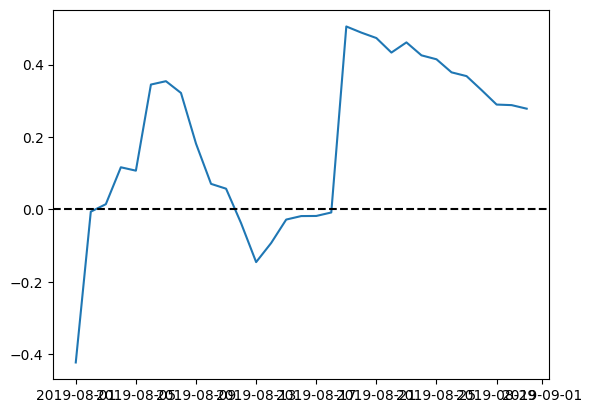

In [ ]:
# plot a relative difference graph for the average purchase sizes
# gathering the data into one DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# plotting a relative difference graph for the average purchase sizes
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA'])-1)
# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')

In [ ]:
# revenue per user
revenue_per_user = clean_orders.groupby(['visitorId'])['revenue'].sum().reset_index()
revenue_per_user.columns = ['visitorId', 'revenue']
revenue_per_user

,visitorId,revenue
0,5114589,10.8
1,6958315,25.9
2,11685486,100.4
3,39475350,65.4
4,47206413,15.2
...,...,...
968,4259830713,50.1
969,4278982564,385.7
970,4279090005,105.3
971,4281247801,45.6


In [ ]:
# see distribution of revenue per user
revenue_per_user['revenue'].describe()

count      973.000000
mean       136.550051
std        663.321828
min          5.000000
25%         20.800000
50%         50.400000
75%        135.200000
max      19920.400000
Name: revenue, dtype: float64

In [ ]:
# Plot the distribution of revenue per user
fig = px.histogram(revenue_per_user['revenue'],
                   x = 'revenue',
                   title = 'Revenue per User Distribution',
                   nbins = 100)
# Update the y-axis label
fig.update_yaxes(title_text= 'users')
fig.show()